In [1]:
import json
from pymongo import MongoClient
import pandas as pd
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral6, inferno
import numpy as np
from bokeh.models import ColumnDataSource
from bokeh.io import show, output_notebook
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [2]:
# Make connection to MongoDB Server
MONGODB_URL=''
client = MongoClient(MONGODB_URL)

In [3]:
# Get list of collections under datamanager folder
database_name = 'datamanager'
database = client[database_name]
collection = database.list_collection_names(include_system_collections=False)
for collect in collection:
    print(collect)

airport_wait_time
clientAiports
flightStatuses
flightTracks
airports
_schema
equipments
requests
airlines
runs


In [4]:
# Get list of all headings under the currently chosen collection (flightTracks)
db = client.datamanager
curs=db.flightTracks.find()
for c in curs[0]:
    print(c)

_id
flightId
bearing
heading
flightNumber
delayMinutes
departureAirportFsCode
departureDate
arrivalAirportFsCode
request_id
carrierFsCode
equipment
tailNumber
callsign
positions


In [5]:
# # Peak at the data in the currently chosen collection (flightTracks) by looking at first entry
# db = client.datamanager
# curs=db.flightTracks.find()
# for c in curs[0:1]:
#     print(c)

In [6]:
# Look at how many distinct entries exist for each of the headings in currently chosen collection (flightTracks)

# info=db.flightTracks.distinct('_id') # 3761 found, ObjectID's inside
# info=db.flightTracks.distinct('flightId') # 3761 found, integers inside
# info=db.flightTracks.distinct('bearing') # 3727 found, floats inside
# info=db.flightTracks.distinct('heading') # 3748 found, floats inside
# info=db.flightTracks.distinct('delayMinutes') # 167 found, integers inside
# info=db.flightTracks.distinct('departureAirportFsCode') # 244 found, airport name strings inside
# info=db.flightTracks.distinct('departureDate') # 2204 found, date dicts inside
# info=db.flightTracks.distinct('arrivalAirportFsCode') # 192 found, airport name strings inside
# info=db.flightTracks.distinct('request_id') # 68 found, ObjectID's inside
# info=db.flightTracks.distinct('carrierFsCode') # 142 found, carrier code strings inside
info=db.flightTracks.distinct('equipment') # 70 found, equipment code strings inside
# info=db.flightTracks.distinct('tailNumber') # 2268 found, tail number strings inside
# info=db.flightTracks.distinct('callsign') # 1205 found, call sign strings inside

# info=db.flightTracks.distinct('positions') # Too large to check as each contains all data along the way

print(len(info))
print(info)

76
['359', '789', '388', '77W', '32B', '744', '788', '333', '772', '321', '75W', '74H', '320', '75C', '332', '7S8', '77X', '74Y', '74N', '77L', '319', '76Y', 'M1F', '76V', '32A', '73W', 'E75', '76W', '73H', '75T', '74E', '73J', '76C', '32Q', '343', '32N', '738', '76E', '31B', '773', '735', 'CR2', 'CR7', '733', 'A81', 'CCX', '32S', 'D1X', '781', '737', 'E90', '717', '736', 'CN7', 'ABY', 'CNJ', '73G', 'CJL', '346', '763', 'D1Y', 'PL2', 'EP3', 'AB3', 'BE9', '33X', 'CN2', '75D', '739', 'CJ8', 'C28', 'CL5', 'LRJ', '330', '76X', 'GJ4']


In [7]:
# Create list of all equipment
equip_list = db.flightTracks.distinct('equipment')

In [8]:
# Definition returns minimum euclidean distance between provided node and target node
def closest_node(comp_node, nodes):
    # Note nodes is a list of tuples
#     print(nodes)
    closest_index = distance.cdist([comp_node], nodes).argmin()
#     print(nodes[closest_index])
    return nodes[closest_index]

In [10]:
# Filter currently chosen collection (flightTracks) by chosen entry from above and display in dataframe
# In this box consider only those flights departing from LAX

def read_in_flights(filter_code,lat_lon_range):
    # No filtering is filter_code=0
    # Filter by departing from LAX is filter_code=1
    # Filter by arriving to LAX is filter_code=2

    lax_coord = [33.9416, -118.4085]
    # Range of latitudes and longitudes around LAX to include
    lat_min = lax_coord[0] - lat_lon_range
    lat_max = lax_coord[0] + lat_lon_range
    lon_min = lax_coord[1] - lat_lon_range
    lon_max = lax_coord[1] + lat_lon_range

    df = pd.DataFrame()
    
    num_flagged = 0
    # Go through each type of equipment one at a time
    for elem in equip_list:

        # Right now only consider planes departing form LAX
        if filter_code == 0:
            data=pd.DataFrame(list(db.flightTracks.find({'equipment':elem})),
                              columns=['_id','departureAirportFsCode','arrivalAirportFsCode','equipment',
                                       'departureDate','positions'])
        elif filter_code == 1:
            data=pd.DataFrame(list(db.flightTracks.find({'equipment':elem ,
                                                     'departureAirportFsCode':'LAX'})),
                         columns=['_id','departureAirportFsCode','arrivalAirportFsCode','equipment',
                                  'departureDate','positions'])
        elif filter_code == 2:
            data=pd.DataFrame(list(db.flightTracks.find({'equipment':elem ,
                                                         'arrivalAirportFsCode':'LAX'})),
                             columns=['_id','departureAirportFsCode','arrivalAirportFsCode','equipment',
                                      'departureDate','positions'])
            
        num_flagged += data.shape[0]
            
        # No go through each flight within this type of equipment
        out = []
        out_dates = []
        first_date_rec = []
        first_date_pos = []
        last_date_rec = []
        last_date_pos = []
        skip_list = [True] * data.shape[0]
        for index in range(data.shape[0]):
            temp_df = pd.DataFrame(data.positions[index],
                                   columns=['lat','lon','altitudeFt','date'])

            # Only include if flight contains points near LAX
            near_node=closest_node(lax_coord, list(zip(temp_df.lat,temp_df.lon)))
            if (near_node[0]<lat_min or near_node[0]>lat_max):
                skip_list[index] = False
            if (near_node[1]<lon_min or near_node[1]>lon_max):
                skip_list[index] = False
            
            # Store as list of tuples
            temp_df['points'] = list(zip(temp_df.lat,temp_df.lon,temp_df.altitudeFt,temp_df.date))
            
            first_date_rec.append(temp_df.date.min())
            last_date_rec.append(temp_df.date.max())
#             print(temp_df.lat.loc[temp_df.date==temp_df.date.min()].item())
            first_date_pos.append((temp_df.lat.loc[temp_df.date==temp_df.date.min()].values[0],
                                  temp_df.lon.loc[temp_df.date==temp_df.date.min()].values[0]))
#             print(temp_df.lat.loc[temp_df.date==temp_df.date.max()].values[0])
#             print(temp_df.lon.loc[temp_df.date==temp_df.date.max()].values[0])
            last_date_pos.append((temp_df.lat.loc[temp_df.date==temp_df.date.max()].values[0],
                                  temp_df.lon.loc[temp_df.date==temp_df.date.max()].values[0]))
            
            # Append list of tuples for particular plane
            out.append(temp_df.points.values)
            out_dates.append(data.departureDate[index]['dateUtc'])

        # Add these tuples to the original dataframe and remove the positions column
        data['points'] = out
        data['date'] = out_dates
        data['First_Date_Rec'] = first_date_rec
        data['Last_Date_Rec'] = last_date_rec
        data['First_Pos_Rec'] = first_date_pos
        data['Last_Pos_Rec'] = last_date_pos
        
        # Before returning filter out those rows flagged as being skipped
        data = data[skip_list]
        
        # Skip if empty
        if data.shape[0]>0:
            data.drop(columns=['positions'],inplace=True)
            # Before moving to next type of equipment merge this with the master dataframe
            df = pd.concat([df, data], axis=0, sort=False)
    
    
    # Split departure date into multiple features
    if not df.empty: # Below only makes sense if at least one flight found
        df['dep_date'] = pd.to_datetime(df['date'])
        df['dep_year'] = df['dep_date'].dt.year 
        df['dep_month'] = df['dep_date'].dt.month 
        df['dep_day'] = df['dep_date'].dt.day 
        df['dep_hour'] = df['dep_date'].dt.hour 
        df['dep_minute'] = df['dep_date'].dt.minute 

    df.reset_index(inplace=True)
    return df, num_flagged


In [11]:
filter_code = 1 # For departing from LAX
lat_lon_range = 2 # Range around LAX to include for filtering
dep_LAX_df, num_flagged = read_in_flights(filter_code,lat_lon_range)

print('In total %i flights found for investigated' % num_flagged)
print('In total %i flights were found for chosen filtering' %dep_LAX_df.shape[0])
dep_LAX_df.head(1)

In total 1373 flights found for investigated
In total 1373 flights were found for chosen filtering


,index,_id,departureAirportFsCode,arrivalAirportFsCode,equipment,departureDate,points,date,First_Date_Rec,Last_Date_Rec,First_Pos_Rec,Last_Pos_Rec,dep_date,dep_year,dep_month,dep_day,dep_hour,dep_minute
0,0,5d0f6fa90473a81fe3146ec5,LAX,TNA,359,"{'dateLocal': '2019-06-23T00:55:00.000', 'date...","[(64.6568, 170.1704, 38000.0, 2019-06-23T14:54...",2019-06-23T07:55:00.000Z,2019-06-23T08:05:00.000Z,2019-06-23T14:54:02.000Z,"(33.94, -118.41)","(64.6568, 170.1704)",2019-06-23 07:55:00+00:00,2019,6,23,7,55


In [12]:
filter_code = 2 # For arriving to LAX
lat_lon_range = 2 # Range around LAX to include for filtering
arr_LAX_df,num_flagged = read_in_flights(filter_code,lat_lon_range)

print('In total %i flights found for investigated' % num_flagged)
print('In total %i flights were found for chosen filtering' %arr_LAX_df.shape[0])
arr_LAX_df.head(1)

In total 2448 flights found for investigated
In total 290 flights were found for chosen filtering


,index,_id,departureAirportFsCode,arrivalAirportFsCode,equipment,departureDate,points,date,First_Date_Rec,Last_Date_Rec,First_Pos_Rec,Last_Pos_Rec,dep_date,dep_year,dep_month,dep_day,dep_hour,dep_minute
0,0,5d0f6fba0473a81fe3146f88,BNE,LAX,789,"{'dateLocal': '2019-06-23T10:20:00.000', 'date...","[(33.9122, -118.7482, 4933.0, 2019-06-23T12:44...",2019-06-23T00:20:00.000Z,2019-06-23T00:28:12.744Z,2019-06-23T12:44:49.000Z,"(-27.3062, 153.2876)","(33.9122, -118.7482)",2019-06-23 00:20:00+00:00,2019,6,23,0,20


In [138]:
# filter_code = 0 # For arriving to LAX
# lat_lon_range = 2 # Range around LAX to include for filtering
# full_df,num_flagged = read_in_flights(filter_code,lat_lon_range)

# print('In total %i flights found for investigated' % num_flagged)
# print('In total %i flights were found for chosen filtering' %full_df.shape[0])
# full_df.head(1)

In [98]:
# print(np.unique(dep_LAX_df.dep_day))
# plt.plot()
# dep_LAX_df.dep_hour.hist(figsize=(10,10),bins=24)
# plt.title('Departing Hour For Flights From LAX')
# plt.xlabel('Time (UTC)')

In [99]:
# full_df['date'] = pd.to_datetime(full_df['date'])
# full_df['year'] = full_df['date'].dt.year 
# full_df['month'] = full_df['date'].dt.month 
# full_df['day'] = full_df['date'].dt.day 
# full_df['hour'] = full_df['date'].dt.hour 
# full_df['minute'] = full_df['date'].dt.minute 

# print(np.unique(full_df.year))
# print(np.unique(full_df.month))
# print(np.unique(full_df.day))
# print(np.unique(full_df.hour))
# # full_df.head()

In [13]:
# Make copy of dataframe to plot and select equipment type to examine
df_plot = dep_LAX_df.copy(deep=True)

# Range of planes to plot
plot_min=0
plot_max=100

p = figure(title="Flight Trajectories Departing From LAX")

# color_mapper = linear_cmap('index', 'Viridis256', 0, df_plot.shape[0])
color_mapper = linear_cmap('index', inferno(256), plot_min, plot_max)

print('There are %i different trajectories chosen for plotting' %(plot_max-plot_min))

for i in range(plot_min,plot_max):

    # Overlay all flights on each other
    temp_df = df_plot.iloc[i-1:i]
    
    # Gather list of latitude and longitude points for each flight separately
    for elem in temp_df.points:
        lat = [item[0] for item in elem]
        lon = [item[1] for item in elem]
        
        index_list = np.ones(len(lat))*i
        source = ColumnDataSource(
            data=dict(lat=lat,
                      lon=lon,
                      index=index_list)
        )

        p.circle(x="lon", y="lat", size=2, fill_alpha=0.1, source=source, color=color_mapper)

output_notebook()  
show(p)

There are 100 different trajectories chosen for plotting


Loading BokehJS ...

Loading BokehJS ...

Text(0.5, 0, 'Time (UTC)')

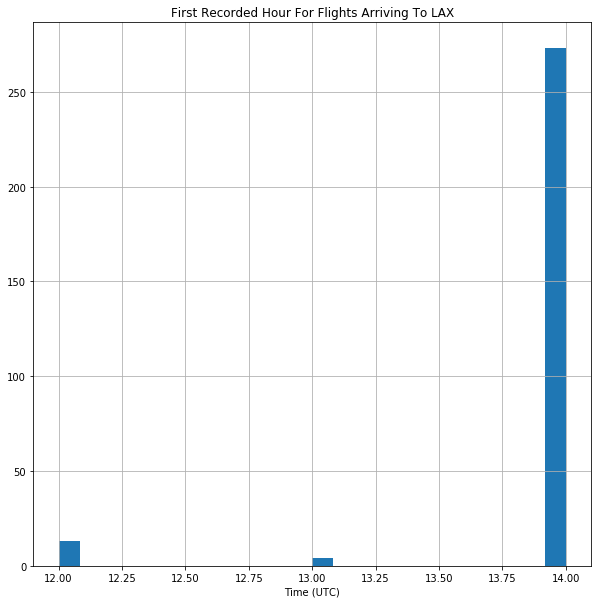

In [14]:
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper

to_inves_df = arr_LAX_df.copy(deep=True)
to_inves = pd.DataFrame({'First_Date_Rec':to_inves_df.First_Date_Rec,'First_Pos_Rec':to_inves_df.First_Pos_Rec,
                         'Last_Date_Rec':to_inves_df.Last_Date_Rec,'Last_Pos_Rec':to_inves_df.Last_Pos_Rec})

# Make into datetime objects
to_inves['First_Date_Rec'] = pd.to_datetime(to_inves['First_Date_Rec'])
to_inves['Last_Date_Rec'] = pd.to_datetime(to_inves['Last_Date_Rec'])

# Add hour features
to_inves['First_Date_Hour'] = to_inves['First_Date_Rec'].dt.hour 
to_inves['Last_Date_Hour'] = to_inves['Last_Date_Rec'].dt.hour 

p = figure(title="Flights Flagged as Departing From LAX")
color_mapper = linear_cmap('time', inferno(4), 12, 15)
# color_mapper = LinearColorMapper(palette="Viridis256", low=13, high=15)
# from bokeh.models import LinearColorMapper
# color_mapper = LinearColorMapper(palette='Viridis256', low = 12, high = 16)


# Go through each flight
lat_list = []
lon_list = []
time_list = []
for i in range(to_inves.shape[0]):
    temp_df = to_inves.iloc[i-1:i]
    # Skip if no data
    if temp_df.shape[0]==0:
        continue
    
    lat_list.append(temp_df.First_Pos_Rec.values[0][0])
    lon_list.append(temp_df.First_Pos_Rec.values[0][1])
    time_list.append(temp_df.First_Date_Hour.values[0])

source = ColumnDataSource(
    data=dict(lat=lat_list,
              lon=lon_list,
              time=time_list)
)


p.circle(x="lon", y="lat", size=4, fill_alpha=0.9, source=source, color=color_mapper)

# from bokeh.models import ColorBar
# bar = ColorBar(color_mapper=color_mapper, location=(0,0))
# p.add_layout(bar, "left")

# plot.add_layout(color_bar, 'right')
    
output_notebook()  
show(p)

plt.plot()
to_inves.Last_Date_Hour.hist(figsize=(10,10),bins=24)
plt.title('First Recorded Hour For Flights Arriving To LAX')
plt.xlabel('Time (UTC)')